In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
data = pd.read_csv('Avocado.csv', index_col='Unnamed: 0')
df = data[(data['region']=='California') & (data['type']=='conventional')]
df

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,0.90,5040365.47,1833946.59,1760956.02,232755.85,1212707.01,1090140.07,110737.35,11829.59,conventional,2015,California
1,2015-12-20,0.94,4695737.21,1676601.43,1543280.76,266689.82,1209165.20,1061703.58,136747.10,10714.52,conventional,2015,California
2,2015-12-13,0.87,5259354.30,1806690.08,1627240.76,232985.13,1592438.33,1404012.00,180150.37,8275.96,conventional,2015,California
3,2015-12-06,0.78,5775536.27,1943065.50,2100246.17,221957.26,1510267.34,1376640.91,126664.37,6962.06,conventional,2015,California
4,2015-11-29,0.91,4575710.62,1461699.38,1810202.70,222311.07,1081497.47,991568.84,82338.39,7590.24,conventional,2015,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-02-04,0.80,10894677.77,4473811.63,4097591.67,146357.78,2176916.69,2072477.62,34196.27,70242.80,conventional,2018,California
8,2018-01-28,1.16,6134040.58,2254631.80,2185495.65,121090.87,1572822.26,1480527.70,24545.94,67748.62,conventional,2018,California
9,2018-01-21,1.12,6610010.64,2378177.09,2590301.70,122950.68,1518581.17,1431898.88,24801.59,61880.70,conventional,2018,California
10,2018-01-14,1.27,5927016.73,2098762.55,2356359.93,151045.33,1320848.92,1226559.09,25390.97,68898.86,conventional,2018,California


In [4]:
df.drop(columns= ["Small Bags", "Large Bags", "XLarge Bags"], axis = 1, inplace = True)
df.drop(columns=['type',"region"], axis = 1,inplace = True)
df["Total Volume"] = np.log(df['Total Volume'] + 1)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df['day'] = df.index.day
df['month'] = df.index.month

# Seasonality
df['seasonality'] = df['month'].apply(lambda x: 1 if x in [7, 8, 9] else (-1 if x in [12, 1, 2] else 0))
# Mark Significant Events
df['significant_event'] = df['year'].apply(lambda x: 1 if x in [2017] else 0)

df

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,year,day,month,seasonality,significant_event
Date,,,,,,,,,,,
2015-01-04,0.93,15.569453,2843648.26,2267755.26,137479.64,528451.74,2015,4,1,-1,0
2015-01-11,0.92,15.611417,2889591.29,2485720.10,103573.42,546047.53,2015,11,1,-1,0
2015-01-18,1.02,15.533070,2780859.66,2108450.36,121614.31,559990.93,2015,18,1,-1,0
2015-01-25,1.06,15.410826,2380955.61,1827783.28,150535.50,570609.87,2015,25,1,-1,0
2015-02-01,0.85,16.016304,4794142.14,3460743.80,177145.49,600149.24,2015,1,2,-1,0
...,...,...,...,...,...,...,...,...,...,...,...
2018-02-25,1.03,15.725107,2666133.31,1947660.32,110662.05,2025905.78,2018,25,2,-1,0
2018-03-04,1.13,15.655351,2380723.98,1676629.99,116796.74,2121378.90,2018,4,3,0,0
2018-03-11,1.11,15.685558,2277437.31,1750118.87,108244.33,2352804.92,2018,11,3,0,0


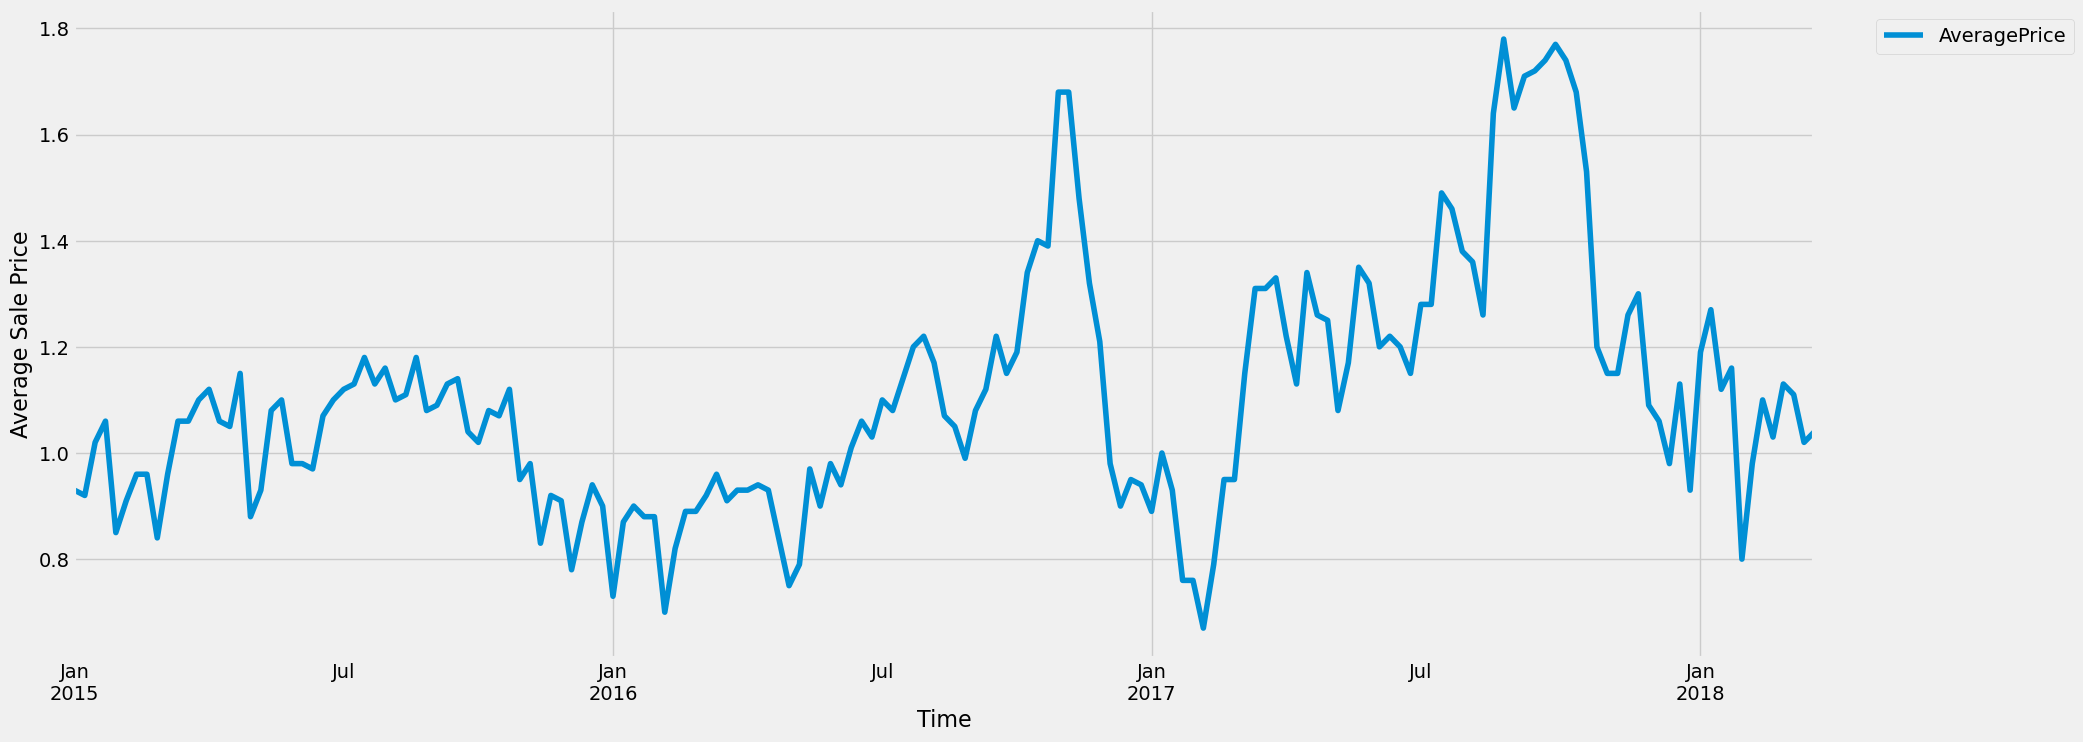

In [5]:
df["AveragePrice"].plot(figsize = (20,8))

plt.legend(bbox_to_anchor=(1.03,1), loc='upper left')
plt.xlabel("Time", fontsize = 16)
plt.ylabel("Average Sale Price", fontsize = 16)
plt.grid(True)
plt.show()

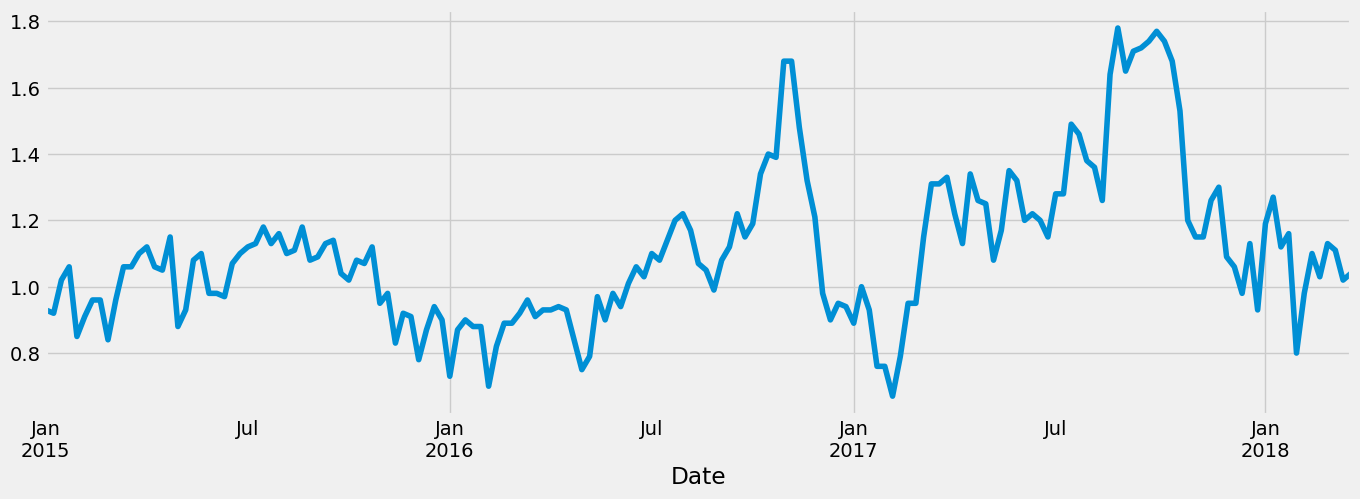

In [6]:
dff = df.copy()
fig, ax = plt.subplots(figsize=(15, 5))
dff["AveragePrice"].plot(ax=ax, label='Training Set')
plt.show()

In [7]:
for i in range(1, 30):
    dff["lag_{}".format(i)] = dff.AveragePrice.shift(i)

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [9]:
tscv = TimeSeriesSplit(n_splits=5)

In [10]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotModelResults(model, X_train, X_test,y_train, y_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    
def plotCoefficients(model, X_train):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [11]:
y = dff.dropna().AveragePrice
X = dff.dropna().drop(['AveragePrice'], axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


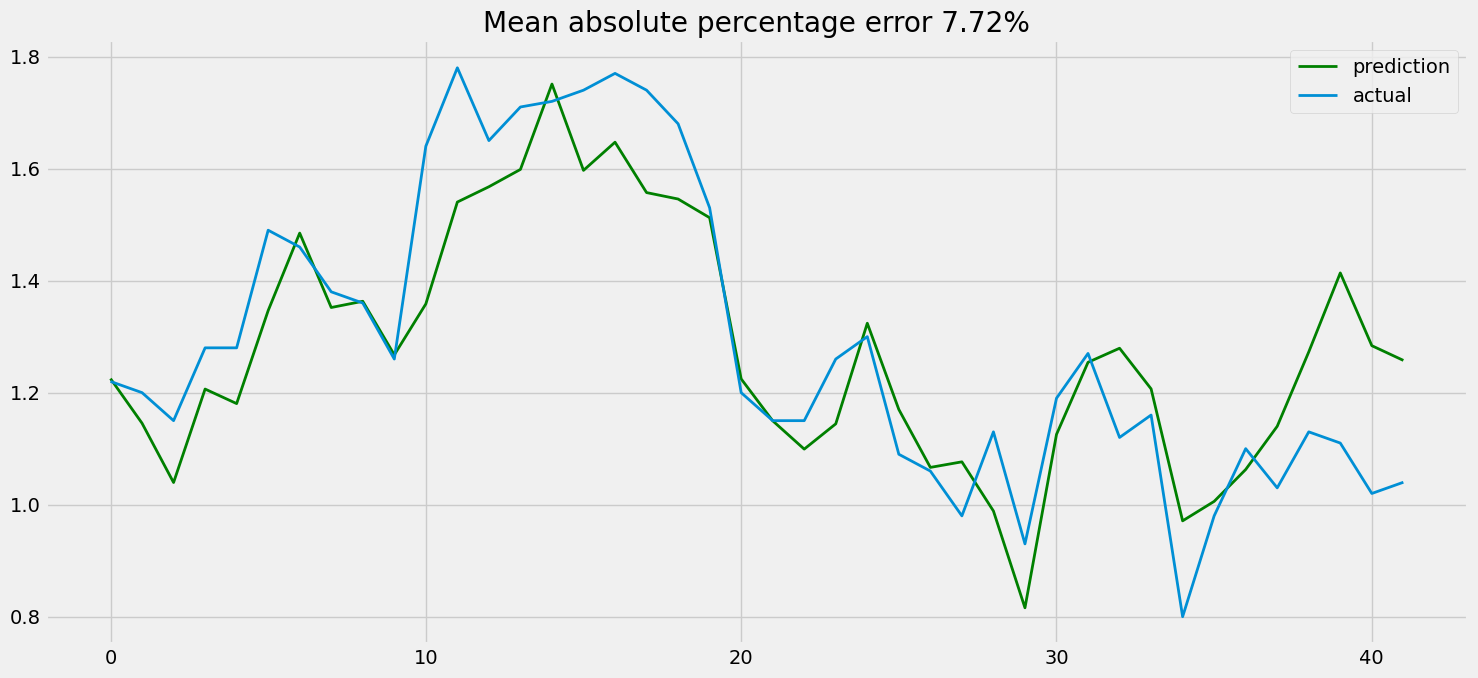

In [12]:
lr = LinearRegression()
param_grid_lr = {
    'fit_intercept': [True, False]
}
grid_search = GridSearchCV(lr, param_grid_lr, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_lr = grid_search.best_estimator_

plotModelResults(best_lr, X_train_scaled, X_test_scaled, y_train, y_test)

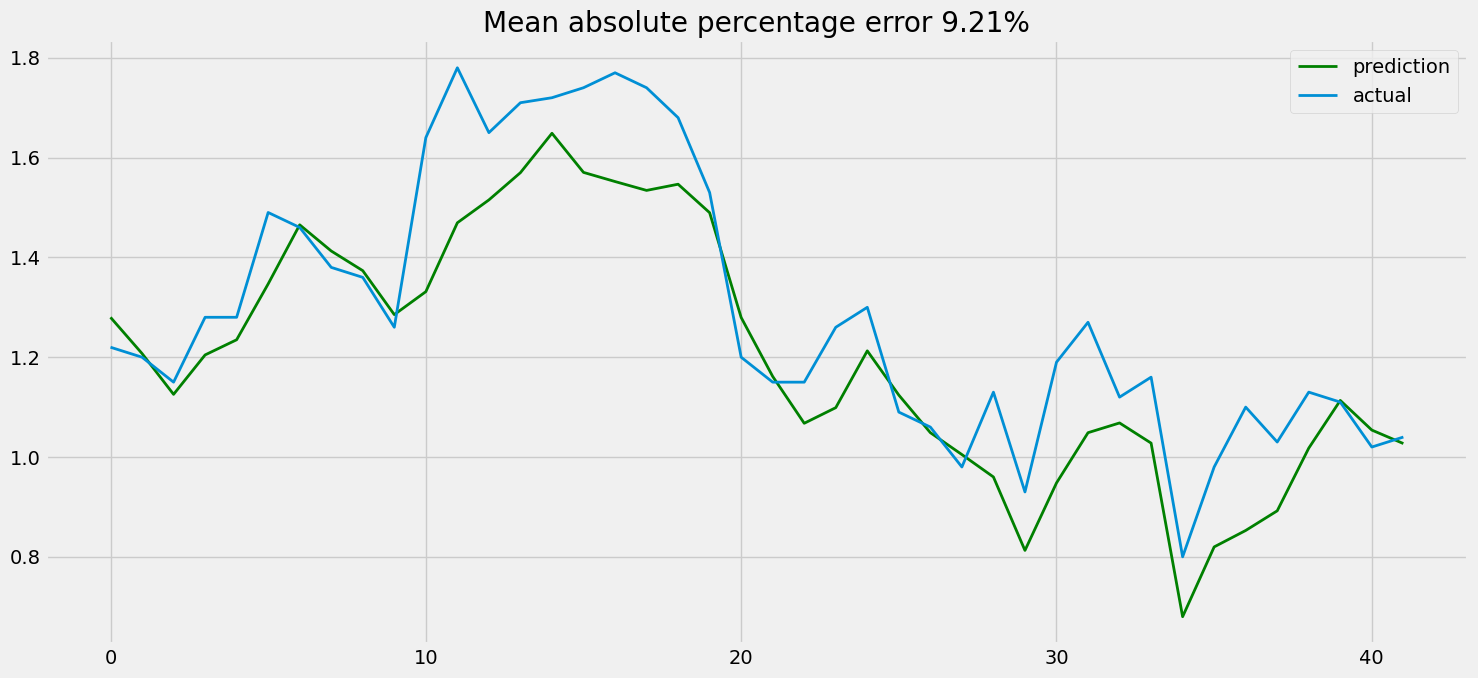

In [13]:
from sklearn.linear_model import Lasso, Ridge
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0],       # Regularization strength
    'fit_intercept': [True, False]   # Whether to fit an intercept        
}
grid_search = GridSearchCV(estimator=Ridge(), param_grid=param_grid_ridge, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_model_ridge = grid_search.best_estimator_

plotModelResults(best_model_ridge, X_train_scaled, X_test_scaled, y_train, y_test)

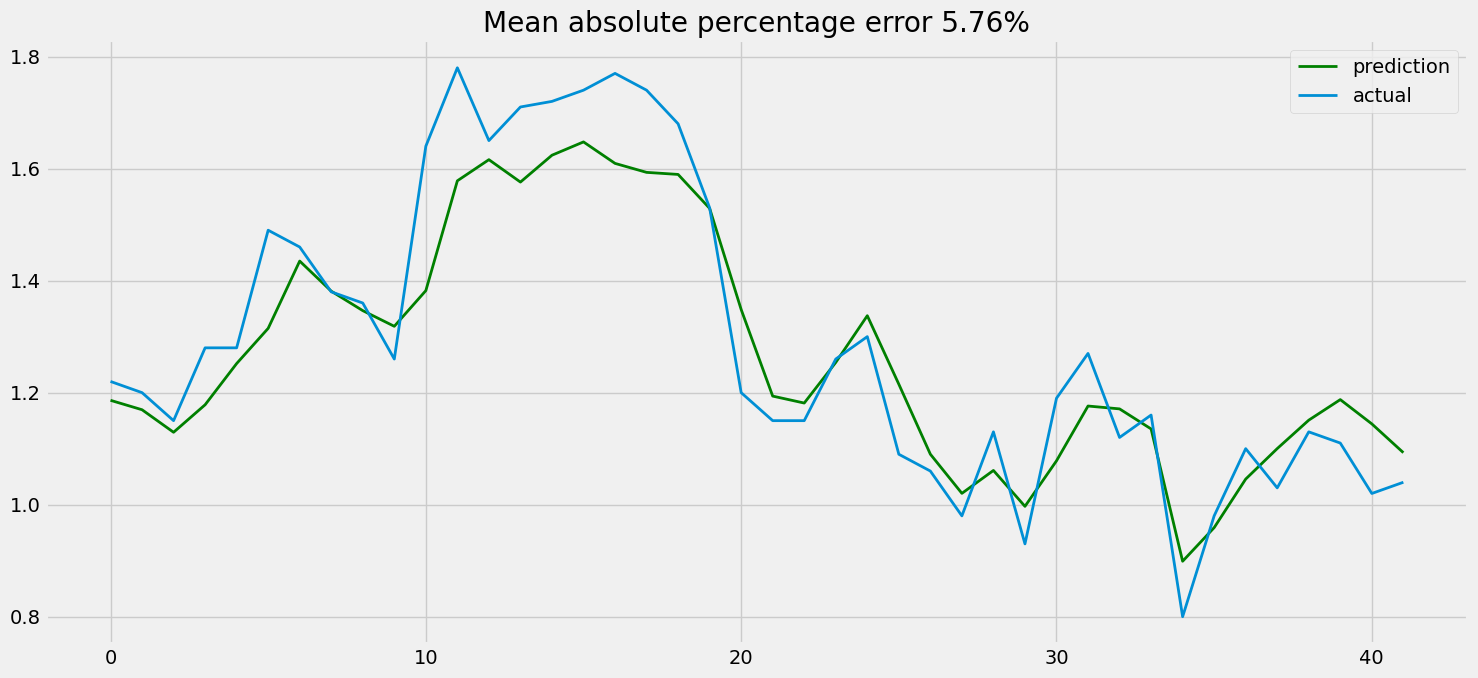

In [14]:
param_grid_lasso = {
    'alpha': [0.01, 0.1, 1.0, 10.0],       # Regularization strength (alpha values to tune)
    'fit_intercept': [True, False],        # Whether to fit an intercept            
    'selection': ['cyclic', 'random']      # Feature selection method
}
grid_search = GridSearchCV(estimator=Lasso(), param_grid=param_grid_lasso, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_model_lasso = grid_search.best_estimator_

plotModelResults(best_model_lasso, X_train_scaled, X_test_scaled, y_train, y_test,
                 plot_intervals=False, plot_anomalies=False)

In [15]:
from xgboost import XGBRegressor 

xgb = XGBRegressor(objective='reg:squarederror')
param_grid_xgb = {
    'n_estimators': [100, 200, 300],                # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.3],               # Step size shrinkage
    'max_depth': [3, 5, 7],                          # Maximum depth of each tree
    'subsample': [0.8, 1.0],                         # Fraction of samples used for training each tree
    'colsample_bytree': [0.8, 1.0],                  # Fraction of features used for training each tree
    'reg_alpha': [0.01, 0.1, 1.0],                    # L1 regularization term
    'reg_lambda': [0.01, 0.1, 1.0],                   # L2 regularization term
    'gamma': [0, 0.1, 0.3]                            # Minimum loss reduction required for further partition
}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_model_xgb = grid_search.best_estimator_

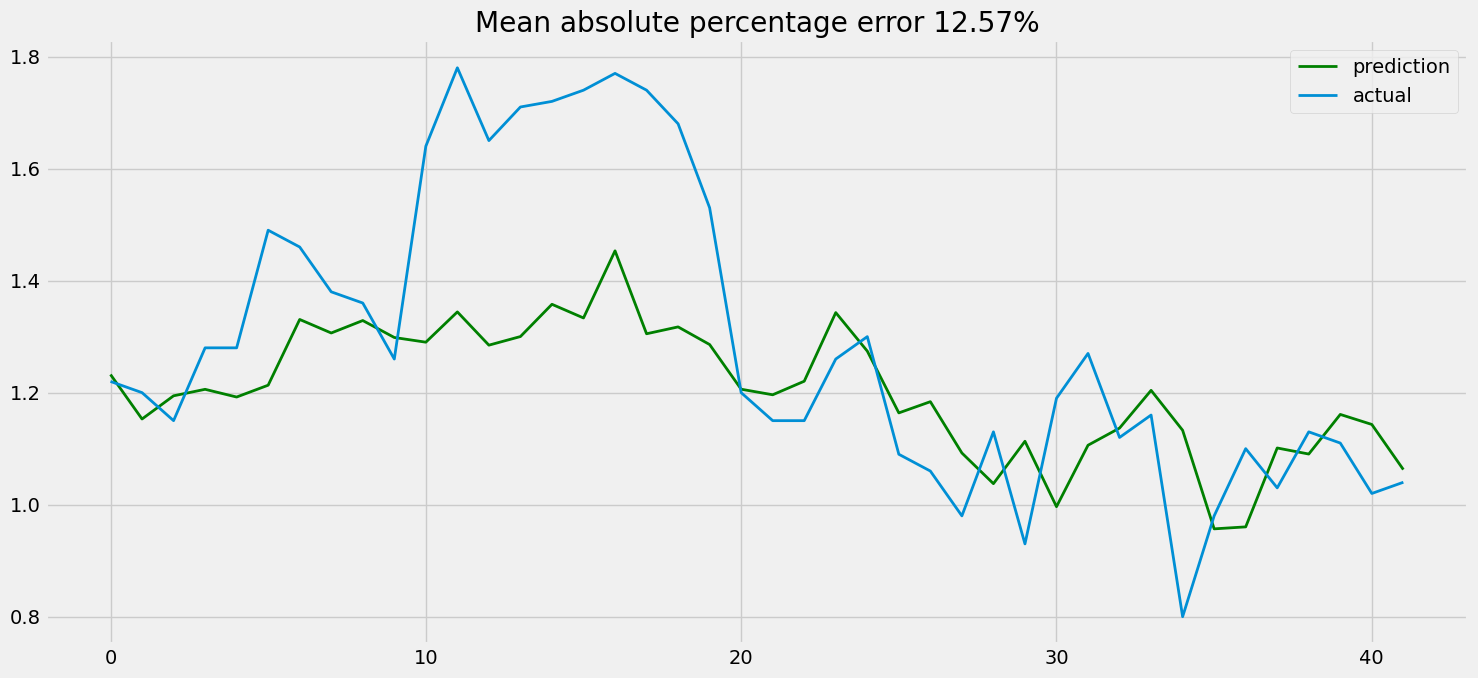

In [16]:
plotModelResults(best_model_xgb, X_train_scaled, X_test_scaled, y_train, y_test,
                 plot_intervals=False, plot_anomalies=True)

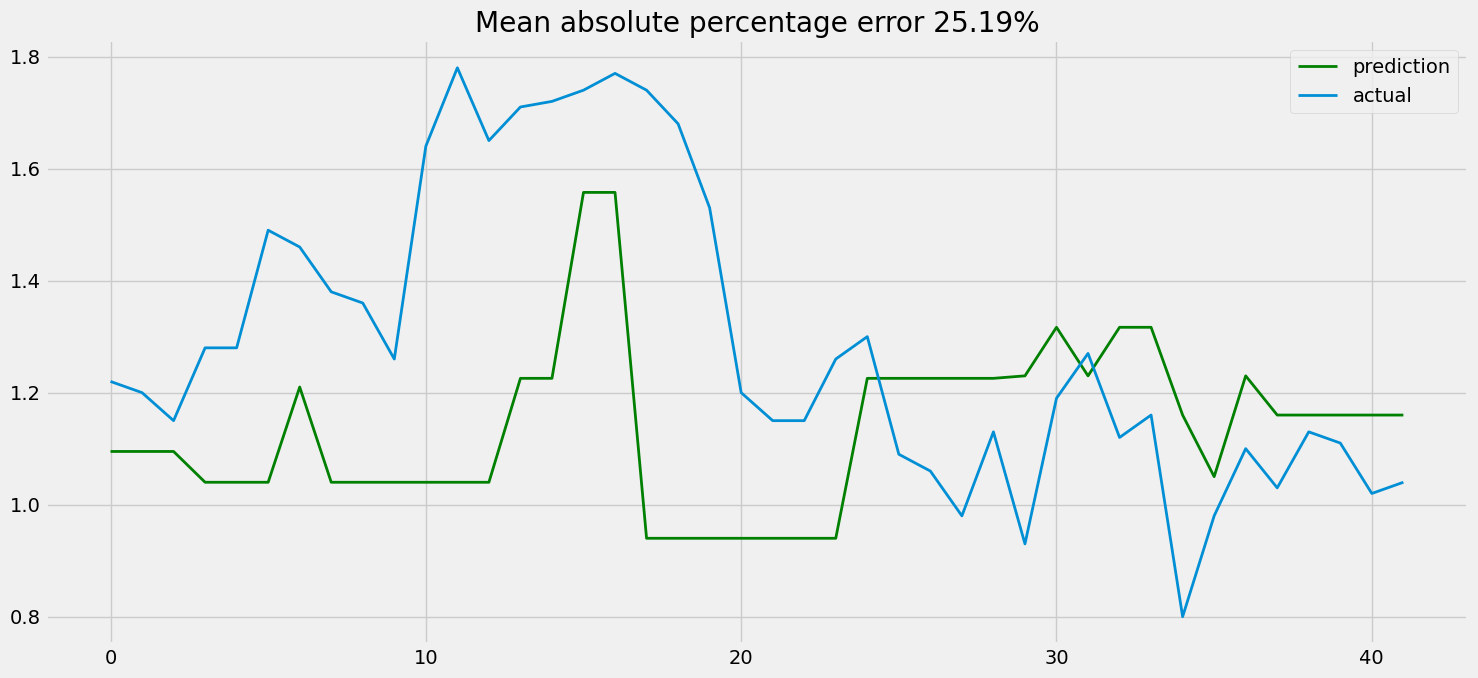

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

tree_param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

forest_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=tree_param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_model_tree = grid_search.best_estimator_

plotModelResults(best_model_tree, X_train_scaled, X_test_scaled, y_train, y_test,
                 plot_intervals=False, plot_anomalies=True)

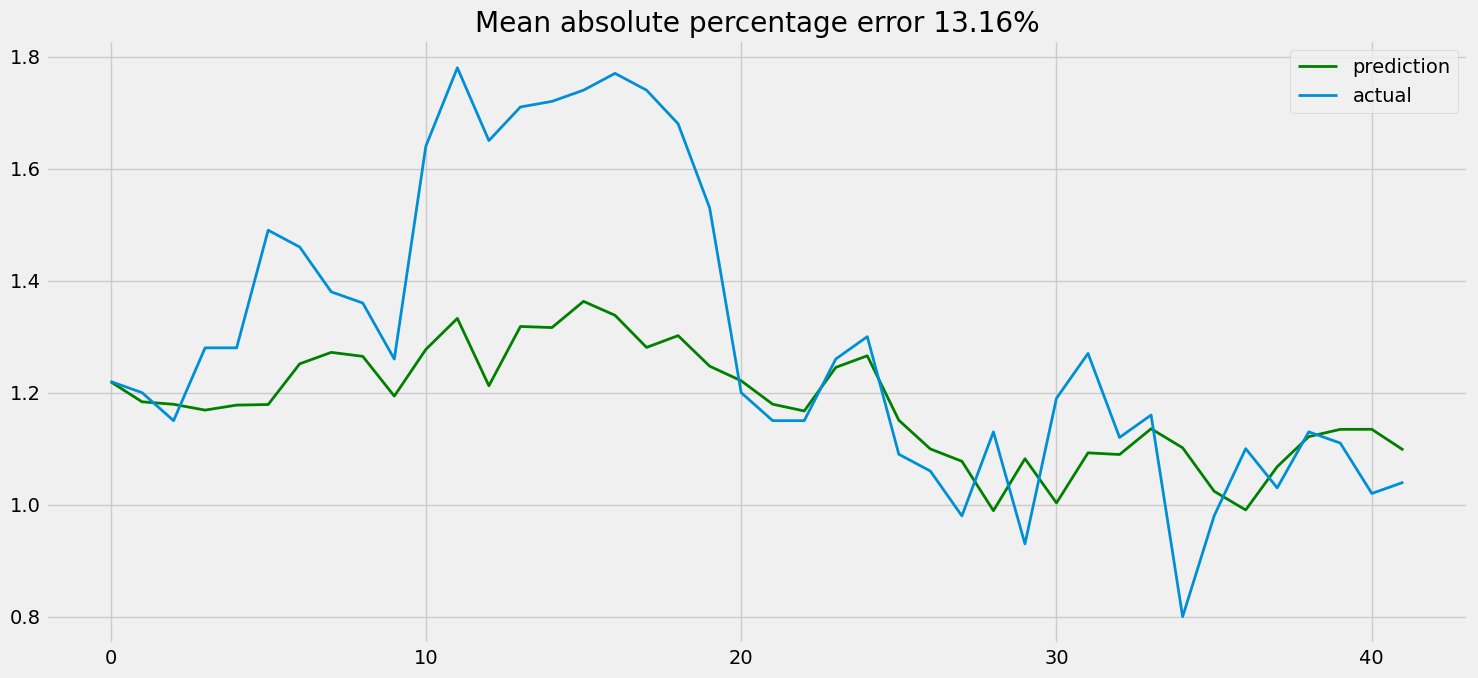

In [18]:
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=forest_param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_model_forest = grid_search.best_estimator_

plotModelResults(best_model_forest, X_train_scaled, X_test_scaled, y_train, y_test,
                 plot_intervals=False, plot_anomalies=True)